In [1]:
from pathlib import Path
import torch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.font_manager import FontProperties, fontManager
from d3s.datasets import D3S, ImageNet, ImageNetC
import json
from collections import defaultdict, OrderedDict
import numpy as np
from itertools import product
import lpips
from tqdm import trange, tqdm
import torchvision.transforms as T
from torch.utils.data import DataLoader, Subset

In [2]:
font_path = "/cmlscratch/pkattaki/void/d3s/d3s/assets/Roboto-Regular.ttf"
fontManager.addfont(font_path)
prop = FontProperties(fname=font_path, weight="regular")
sns.set(font=prop.get_name())

In [3]:
plots_folder = Path("/cmlscratch/pkattaki/void/d3s/d3s/outputs/plots")

In [4]:
TYPE = "type"
EXTRA_DATA = "extra_data"
ADV = "2_adv"
CLIP = "5_clip"
CNN = "0_cnn"
TRANSFORMER = "1_transformer"
SELF_SUP = "4_self_sup"
SEMI_SUP = "3_semi_sup"

models = {
    "resnet50": {TYPE: CNN, EXTRA_DATA: False},
    "resnext50_32x4d": {TYPE: CNN, EXTRA_DATA: False},
    "densenet121": {TYPE: CNN, EXTRA_DATA: False},
    "efficientnet_b0": {TYPE: CNN, EXTRA_DATA: False},
    "vit_base_patch16_224": {TYPE: TRANSFORMER, EXTRA_DATA: False},
    "vit_large_patch32_384": {TYPE: TRANSFORMER, EXTRA_DATA: False},
    "vit_base_patch16_224_sam": {TYPE: TRANSFORMER, EXTRA_DATA: False},
    "vit_base_patch16_224_miil": {TYPE: TRANSFORMER, EXTRA_DATA: True},
    "inception_resnet_v2": {TYPE: CNN, EXTRA_DATA: False},
    "mobilenetv3_small_100": {TYPE: CNN, EXTRA_DATA: False},
    "mobilenetv2_140": {TYPE: CNN, EXTRA_DATA: False},
    "resnetv2_101x3_bitm": {
        TYPE: CNN,
        EXTRA_DATA: True,
    },
    "resnetv2_50x1_bit_distilled": {
        TYPE: CNN,
        EXTRA_DATA: True,
    },
    "ssl_resnet50": {
        TYPE: SEMI_SUP,
        EXTRA_DATA: True,
    },
    "ssl_resnext50_32x4d": {
        TYPE: SEMI_SUP,
        EXTRA_DATA: True,
    },
    "swsl_resnet50": {
        TYPE: SEMI_SUP,
        EXTRA_DATA: True,
    },
    "swsl_resnext50_32x4d": {
        TYPE: SEMI_SUP,
        EXTRA_DATA: True,
    },
    "adv_inception_v3": {
        TYPE: ADV,
        EXTRA_DATA: False,
    },
    "ens_adv_inception_resnet_v2": {
        TYPE: ADV,
        EXTRA_DATA: False,
    },
    "dino_vitb8": {TYPE: SELF_SUP, EXTRA_DATA: False},
    "dino_resnet50": {TYPE: SELF_SUP, EXTRA_DATA: False},
    "beit_base_patch16_224": {TYPE: SELF_SUP, EXTRA_DATA: False},
    "beit_large_patch16_512": {TYPE: SELF_SUP, EXTRA_DATA: False},
    "beitv2_large_patch16_224": {TYPE: SELF_SUP, EXTRA_DATA: False},
    "deit_base_patch16_384": {TYPE: TRANSFORMER, EXTRA_DATA: False},
    "deit3_huge_patch14_224": {TYPE: TRANSFORMER, EXTRA_DATA: False},
    "deit3_huge_patch14_224_in21ft1k": {
        TYPE: TRANSFORMER,
        EXTRA_DATA: True,
    },
    "clip-RN50": {TYPE: CLIP, EXTRA_DATA: True},
    "clip-RN50x64": {TYPE: CLIP, EXTRA_DATA: True},
    "clip-ViT-B/32": {TYPE: CLIP, EXTRA_DATA: True},
    "clip-ViT-L/14@336px": {TYPE: CLIP, EXTRA_DATA: True},
    "robust_resnet50_l2": {TYPE: ADV, EXTRA_DATA: False},
    "robust_resnet50_linf": {TYPE: ADV, EXTRA_DATA: False},
}


In [5]:
d3s_eval_stats_folder = Path("/cmlscratch/pkattaki/void/d3s/d3s/outputs/d3s_eval_stats")
d3s_eval_stats = OrderedDict()
for model_stats_path in d3s_eval_stats_folder.glob("*.pt"):
    model_name = model_stats_path.stem
    if model_name.startswith("clip-ViT"):
        model_name = model_name[:10] + "/" + model_name[11:]
    d3s_eval_stats[model_name] = torch.load(model_stats_path)
print(f"Found stats for {len(d3s_eval_stats)} models")

Found stats for 33 models


## Generalization Gap

In [6]:
def compute_generalization_gap(stats):
    imagenet_top1 = stats["imagenet_top1"]
    d3s_top1 = stats["d3s_top1"]
    return imagenet_top1 - d3s_top1

In [7]:
NAME = "model_name"
GAP = "generalization_gap"
TYPE_LABEL = "type_label"
type_labels = {
    CNN: "CNN",
    TRANSFORMER: "Transformer",
    ADV: "Adversarially Trained",
    SEMI_SUP: "Semi-Supervised",
    SELF_SUP: "Self-Supervised",
    CLIP: "CLIP (Zero Shot)"
}

generalization_gaps = {name: compute_generalization_gap(stats) for name, stats in d3s_eval_stats.items()}
generalization_gaps_df = pd.DataFrame.from_dict(generalization_gaps, orient="index", columns=[GAP])
generalization_gaps_df[TYPE] = [models[m][TYPE] for m in generalization_gaps_df.index]
generalization_gaps_df[TYPE_LABEL] = [type_labels[t] for t in generalization_gaps_df[TYPE]]
generalization_gaps_df[EXTRA_DATA] = [models[m][EXTRA_DATA] for m in generalization_gaps_df.index]
generalization_gaps_df.reset_index(inplace=True)
generalization_gaps_df = generalization_gaps_df.rename(columns={"index": NAME})
generalization_gaps_df = generalization_gaps_df.sort_values(by=[TYPE, NAME])
print(generalization_gaps_df)

                         model_name  generalization_gap           type  \
29                      densenet121           10.988829          0_cnn   
9                   efficientnet_b0           12.770204          0_cnn   
17              inception_resnet_v2           14.249634          0_cnn   
8                   mobilenetv2_140           12.721649          0_cnn   
12            mobilenetv3_small_100           13.466874          0_cnn   
6                          resnet50           16.836718          0_cnn   
22              resnetv2_101x3_bitm           15.374647          0_cnn   
31      resnetv2_50x1_bit_distilled           13.699884          0_cnn   
18                  resnext50_32x4d           16.125038          0_cnn   
5            deit3_huge_patch14_224           15.889189  1_transformer   
1   deit3_huge_patch14_224_in21ft1k           14.612799  1_transformer   
2             deit_base_patch16_384           17.463357  1_transformer   
0              vit_base_patch16_224   

In [8]:
fig = plt.figure(dpi=1200)
fig.set_figwidth(12)
ax = sns.barplot(generalization_gaps_df, x=NAME, y=GAP, hue=TYPE_LABEL, dodge=False)
ax.set_xlabel("Model Architecture")
ax.set_ylabel("Drop in Top-1 Accuracy")
ax.set_title("Robustness on the D3S Benchmark")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# hack to hatch bars for models with extra data
containers = list(ax.containers)
for row_idx, row in enumerate(generalization_gaps_df.itertuples()):
    is_extra_data = row[row._fields.index(EXTRA_DATA)]
    if is_extra_data:
        model_type = row[row._fields.index(TYPE)]
        bars = list(containers[int(model_type[0])])
        bars[row_idx].set_hatch("//")
        
ax.get_legend().set_title("")
plt.xticks(rotation=90, fontsize=6)
plt.tight_layout()
plt.savefig(plots_folder / "generalization_gap.pdf")

## Foreground vs. Background

In [9]:
def compute_fg_bg_accuracy(stats):
    d3s_stats = stats["d3s_stats"]
    correct = torch.cat((d3s_stats[0], d3s_stats[0].sum(dim=-1, keepdim=True)), dim=-1)
    total = torch.cat((d3s_stats[2], d3s_stats[2].sum(dim=-1, keepdim=True)), dim=-1)
    return 100 * correct / (1e-8 + total)
d3s_val = D3S("/cmlscratch/pkattaki/datasets/d3s", split="val")

In [10]:
COARSE_LABEL = "coarse_label"
coarse_labels = {
    0: "Dog",
    1: "Bird",
    2: "Vehicle",
    3: "Reptile",
    4: "Carnivore",
    5: "Insect",
    6: "Instrument",
    7: "Primate",
    8: "Fish",
    -1: "Miscellaneous"
}
with open("/cmlscratch/pkattaki/void/d3s/d3s/assets/in_to_in9.json", "r") as f:
    in_to_in9 = json.load(f)
    imagenet_to_coarse_label = {int(k): coarse_labels[v] for k, v in in_to_in9.items()}
    coarse_label_to_imagenet = defaultdict(list)
    for k, v in imagenet_to_coarse_label.items():
        coarse_label_to_imagenet[v].append(k)

In [11]:
fg_bg_accuracies_unreduced = torch.stack([compute_fg_bg_accuracy(stats) for stats in d3s_eval_stats.values()]).numpy()
fg_bg_accuracies = np.mean(fg_bg_accuracies_unreduced, axis=0)
fg_bg_accuracies_df = pd.DataFrame.from_records(fg_bg_accuracies)
fg_bg_accuracies_df.columns = d3s_val.backgrounds + ["all"]
fg_bg_accuracies_df[COARSE_LABEL] = [imagenet_to_coarse_label[idx] for idx in fg_bg_accuracies_df.index]
fg_bg_accuracies_df.head()

<bound method NDFrame.head of           grass       road     forest      water        sand    indoors  \
0      0.000000  77.272728  21.212122  86.868690   67.676765  75.757576   
1    100.000000  99.242424   0.000000  96.969696   86.868683  98.989891   
2     81.818184  80.808090  63.636364  86.868698  100.000000  78.181816   
3     57.575756  74.242424  87.878784  56.060608   58.585861  90.909088   
4     75.757576   9.090909  12.121212  44.696968   72.727272  33.939392   
..          ...        ...        ...        ...         ...        ...   
995    0.000000   0.000000  19.696970   9.090909   33.333332  69.696968   
996    0.000000  30.303030  45.454544  18.181818    0.000000  25.757576   
997   18.181818   7.070706  28.484848   6.060606   18.181818   6.060606   
998    0.000000  40.404037  68.181816  81.818184   59.090908   0.000000   
999   39.393944   0.000000  24.242424  36.363636   42.424244  81.818184   

          snow       rain      night        cave        all   coarse_

In [12]:
def gather_fg_bg(fg, bg):
    bg_idx = d3s_val.backgrounds.index(bg)
    gathered = fg_bg_accuracies_unreduced[:, coarse_label_to_imagenet[fg], bg_idx]
    return np.mean(gathered, axis=-1)

In [13]:
d3s_top1 = np.array([stats["d3s_top1"] for stats in d3s_eval_stats.values()])
fg_bg_robustness = []
for fg, bg in product(coarse_label_to_imagenet.keys(), d3s_val.backgrounds):
    robustness = gather_fg_bg(fg, bg).mean() - d3s_top1.mean()
    fg_bg_robustness.append((robustness, fg, bg))
fg_bg_robustness.sort(key=lambda x: x[0])
worst_robust_pairs = [(fg, bg) for _, fg, bg in fg_bg_robustness[:3]] 
best_robust_pairs = [(fg, bg) for _, fg, bg in fg_bg_robustness[-3:]]
print(f"Worst: {fg_bg_robustness[:3]}")
print(f"Best: {fg_bg_robustness[-3:]}")

Worst: [(-35.20692840497158, 'Primate', 'forest'), (-34.805410536929585, 'Primate', 'water'), (-31.45568290631435, 'Reptile', 'sand')]
Best: [(8.39274772723057, 'Carnivore', 'snow'), (8.43448814471104, 'Bird', 'rain'), (9.862336960629008, 'Carnivore', 'water')]


In [14]:
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(10)
fig.set_dpi(1200)

eq_data = np.linspace(40, 80, num=10)
eq_df = pd.DataFrame({"x": eq_data, "y": eq_data})

for i, (fg, bg) in enumerate(worst_robust_pairs + best_robust_pairs):
    df = pd.DataFrame({"d3s_top1": d3s_top1, "fg_bg": gather_fg_bg(fg, bg), NAME: models.keys()})
    df[TYPE] = [models[m][TYPE] for m in df[NAME]]
    df[TYPE_LABEL] = [type_labels[t] for t in df[TYPE]]
    
    row_idx = i // 3
    col_idx = i % 3

    sns.scatterplot(df, x="d3s_top1", y="fg_bg", hue=TYPE_LABEL, ax=axs[row_idx][col_idx])
    sns.lineplot(eq_df, x="x", y="y", linestyle="--", color="gray", ax=axs[row_idx][col_idx])
    axs[row_idx][col_idx].get_legend().remove()
    axs[row_idx][col_idx].set_title(f"{fg}, {bg.capitalize()}")
    if row_idx == 1:
        axs[row_idx][col_idx].set_xlabel("Top-1 Accuracy on D3S")
    else:
        axs[row_idx][col_idx].set_xlabel("")
    if col_idx == 0:
        axs[row_idx][col_idx].set_ylabel("Top-1 Accuracy (FG on BG)")
    else:
        axs[row_idx][col_idx].set_ylabel("")

plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(plots_folder / "fg_bg_robustness.pdf")

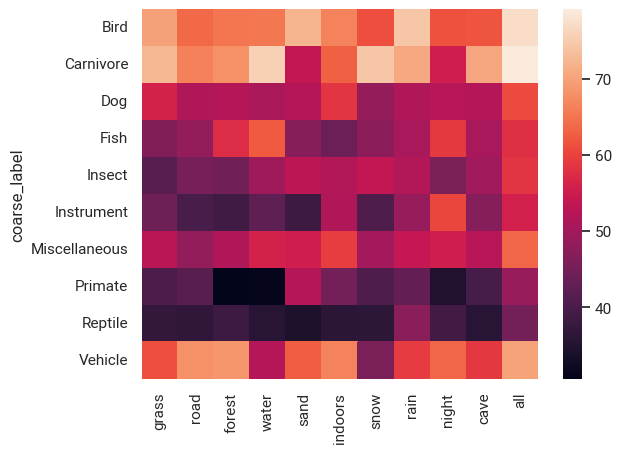

In [15]:
sns.heatmap(fg_bg_accuracies_df.groupby(COARSE_LABEL).mean())

In [13]:
from d3s.pretrained_models import RobustResNet50
import torch.nn as nn
feature_extractor = RobustResNet50("robust_resnet50_l2")
transform = feature_extractor.transform
feature_extractor.eval()
feature_extractor.cuda()
feature_dim = feature_extractor.model.model.fc.in_features
feature_extractor.model.model.fc = nn.Identity()

=> loading checkpoint '/nfshomes/pkattaki/.cache/torch/hub/robustness/robust_resnet_l2_e3.0.pt'
=> loaded checkpoint '/nfshomes/pkattaki/.cache/torch/hub/robustness/robust_resnet_l2_e3.0.pt' (epoch 105)


In [14]:
d3s_train = D3S("/cmlscratch/pkattaki/datasets/d3s", split="train", transform=transform)
imagenet_train = ImageNet(split="train", transform=transform)
imagenet_c = ImageNetC("all", "all", transform=transform)
dataset_names = ["D3S", "ImageNet", "ImageNet-C"]

In [38]:
rng = np.random.default_rng()
num_samples = 50
num_classes = 50
class_idxs = rng.choice(len(imagenet_train.classes), size=num_classes, replace=False)
datasets = [d3s_train, imagenet_train, imagenet_c]
dataset_svals = {}
with torch.no_grad():
    for dataset_name, dataset in zip(dataset_names, datasets):
        features = torch.zeros(num_classes, num_samples, feature_dim).cuda()
        for i, class_idx in enumerate(class_idxs):
            options = dataset.class_to_indices[class_idx]
            samples = [dataset[idx] for idx in rng.choice(options, size=num_samples, replace=False)]
            images = torch.stack([sample[0] for sample in samples]).cuda()
            features[i] = feature_extractor(images)
        dataset_svals[dataset_name] = torch.linalg.svdvals(features).mean(0).cpu().numpy()
        

In [41]:
for dataset_name in dataset_names:
    dataset_svals[dataset_name] /= np.linalg.norm(dataset_svals[dataset_name])

<bound method NDFrame.head of          D3S  ImageNet  ImageNet-C
0   0.792722  0.777010    0.713735
1   0.217349  0.237867    0.252859
2   0.183188  0.191084    0.216773
3   0.162192  0.165057    0.189085
4   0.148060  0.150869    0.171711
5   0.138923  0.138941    0.158910
6   0.130217  0.129875    0.148503
7   0.123242  0.123340    0.139927
8   0.115951  0.116985    0.132477
9   0.110411  0.111509    0.125993
10  0.105408  0.107249    0.120501
11  0.100688  0.102746    0.115995
12  0.097052  0.098988    0.111191
13  0.093680  0.094938    0.107200
14  0.090238  0.092246    0.102707
15  0.086796  0.089148    0.099317
16  0.084521  0.086369    0.096104
17  0.081542  0.083561    0.092846
18  0.079050  0.081005    0.089894
19  0.076437  0.078837    0.087142
20  0.074092  0.076814    0.084590
21  0.072055  0.074564    0.082110
22  0.069905  0.072308    0.080177
23  0.068068  0.070512    0.077947
24  0.066413  0.068716    0.076073
25  0.064506  0.067029    0.073813
26  0.062998  0.065479   

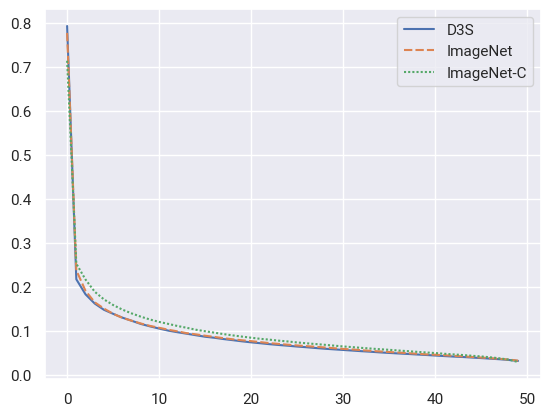

In [42]:
dataset_svals_df = pd.DataFrame.from_dict(dataset_svals)
print(dataset_svals_df.head())
sns.lineplot(data=dataset_svals_df)

In [9]:
rng = np.random.default_rng()

In [54]:
num_samples = 30
num_classes = 30
class_idxs = rng.choice(len(imagenet_train.classes), num_classes, replace=False)
datasets = [d3s_train, imagenet_train, imagenet_c]
dataset_vars = {dataset_name: np.zeros(num_classes) for dataset_name in dataset_names}
with torch.no_grad():
    for dataset_name, dataset in zip(dataset_names, datasets):
        for i, class_idx in enumerate(tqdm(class_idxs, desc=f"Evaluating on {dataset_name}")):
            options = dataset.class_to_indices[class_idx]
            samples = [dataset[idx] for idx in rng.choice(options, size=num_samples, replace=False)]
            images = torch.stack([sample[0] for sample in samples]).cuda()
            dataset_vars[dataset_name][i] = feature_extractor(images).var(dim=0).mean() 

Evaluating on ImageNet-C: 100%|█████████████████████████████████████████████████████████| 30/30 [00:23<00:00,  1.30it/s]


        D3S  ImageNet  ImageNet-C
0  0.076883  0.104961    0.086366
1  0.090876  0.140590    0.107395
2  0.085646  0.082621    0.074601
3  0.065174  0.072066    0.071514
4  0.090645  0.097832    0.067460


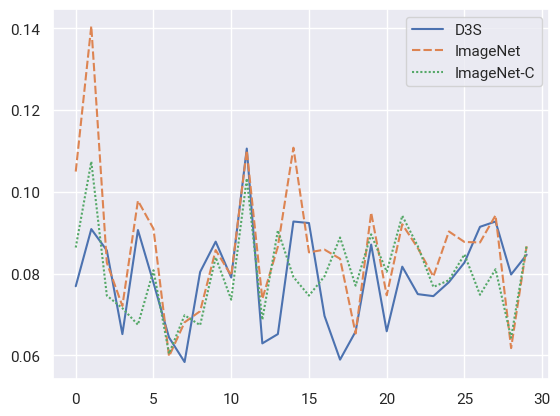

In [57]:
dataset_vars_df = pd.DataFrame.from_dict(dataset_vars)
print(dataset_vars_df.head())
sns.lineplot(data=dataset_vars_df)

In [7]:
lpips_transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
lpips_d3s = D3S("/cmlscratch/pkattaki/datasets/d3s", split="train", transform=lpips_transform)
lpips_imagenet = ImageNet(split="train", transform=lpips_transform)
lpips_imagenet_c = ImageNetC("all", "all", transform=lpips_transform)

In [15]:
lpips_distance = lpips.LPIPS(net="alex").cuda()
num_samples_per_class = 50
num_classes = 50
class_idxs = rng.choice(len(lpips_d3s.classes), num_classes, replace=False)
num_samples = num_samples_per_class * num_classes
distances = defaultdict(list)
mean_distances = {dataset_name: np.zeros(num_classes) for dataset_name in dataset_names}


for dataset_name, dataset in zip(dataset_names, [lpips_d3s, lpips_imagenet, lpips_imagenet_c]):
    with trange(num_samples) as pbar:
        for i, class_idx in enumerate(class_idxs):
            idxes = dataset.class_to_indices[class_idx]
            pairs = list(product(idxes, repeat=2))
            samples = rng.choice(pairs, size=num_samples_per_class)
            for sample in samples:
                img1, img2 = sample
                img1, img2 = dataset[img1][0].cuda(), dataset[img2][0].cuda()

                distances[class_idx].append(lpips_distance.forward(img1, img2).item())
                pbar.update(1)
            mean_distances[dataset_name][i] = np.mean(np.array(distances[class_idx]))

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/cmlscratch/pkattaki/developer/anaconda3/envs/ldm/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/cmlscratch/pkattaki/developer/anaconda3/envs/ldm/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /cmlscratch/pkattaki/developer/anaconda3/envs/ldm/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth


100%|███████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:23<00:00, 17.38it/s]


In [ ]:
mean_distances_df = pd.DataFrame.from_dict(mean_distances)
sns.lineplot(data=mean_distances_df)

In [73]:
distances = defaultdict(list)
with trange(3 * num_samples) as pbar:
    for i, class_idx in enumerate(class_idxs):
        d3s_idxes = lpips_d3s.class_to_indices[class_idx]
        imagenet_idxes = lpips_imagenet.class_to_indices[class_idx]
        d3s_pairs = list(product(d3s_idxes, repeat=2))
        samples = rng.choice(d3s_pairs, size=num_samples_per_class)
        for sample in samples:
            img1, img2 = sample
            img1, img2 = lpips_d3s[img1][0].cuda(), lpips_d3s[img2][0].cuda()

            distances["Within D3S"].append(lpips_distance.forward(img1, img2).item())
            pbar.update(1)
        imagenet_pairs = list(product(imagenet_idxes, repeat=2))
        samples = rng.choice(imagenet_pairs, size=num_samples_per_class)
        for sample in samples:
            img1, img2 = sample
            img1, img2 = lpips_imagenet[img1][0].cuda(), lpips_imagenet[img2][0].cuda()

            distances["Within ImageNet"].append(lpips_distance.forward(img1, img2).item())
            pbar.update(1)
        cross_pairs = list(product(imagenet_idxes, d3s_idxes))
        samples = rng.choice(cross_pairs, size=num_samples_per_class)
        for sample in samples:
            img1, img2 = sample
            img1, img2 = lpips_imagenet[img1][0].cuda(), lpips_d3s[img2][0].cuda()

            distances["From ImageNet to D3S"].append(lpips_distance.forward(img1, img2).item())
            pbar.update(1)

100%|███████████████████████████████████████████████████████████████████████████████| 7500/7500 [05:53<00:00, 21.23it/s]


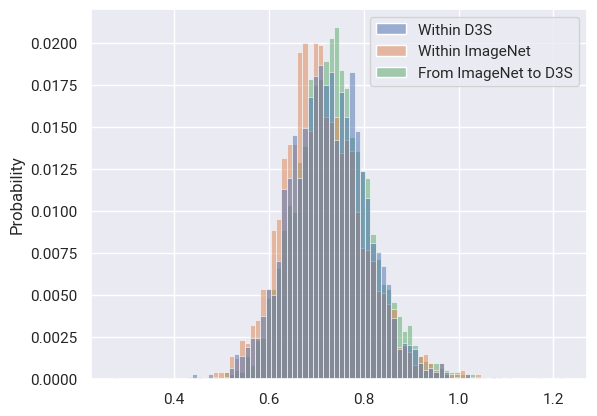

In [91]:
distances_df = pd.DataFrame.from_dict(distances)
filtered_df = distances_df.loc[lambda x: (x["Within D3S"] != 0) & (x["Within ImageNet"] != 0)]
# filtered_df = filtered_df.drop("From ImageNet to D3S", axis=1)
sns.histplot(data=filtered_df, stat="probability")